In [40]:
import cvxpy as cp
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt

In [154]:
def DCOPF(Y,PGl,PGu,PD,thetaL,thetaU,CQ,CL,PF,slack,gens_to_buses,eff_in,eff_out,eff_store,max_charge,b_cost,b_lifetime,max_b_size):
    num_buses = len(Y)
    num_generators = PGl.shape[1]
    B = np.imag(Y)
    t = len(PD)

    PG = cp.Variable((t,num_generators)); # optimization variable: PG_i
    theta = cp.Variable((t,num_buses)); # optimization variable: theta_i
    S = cp.Variable((t+1,num_buses));
    qR = cp.Variable((t,num_buses));
    qD = cp.Variable((t,num_buses));
    Smaxs = cp.Variable(num_buses);

    objective = cp.Minimize(cp.sum(PG**2 * CQ.T + PG * CL.T) + (t/b_lifetime) * b_cost * cp.sum(Smaxs)) # objective function

    constraints = [
        # Power generation constraints
        PG - PGu <= 0,
        -PG + PGl <= 0,

        #Bus phase angle constraints
        theta.T - thetaU <= 0,
        -theta.T + thetaL <= 0,

        #Power balance constraint
        qR + theta * B + PD == PG * gens_to_buses + qD*eff_out,

        #Slack angle constraint   
        theta[:,slack] == 0,
        
        # Storage dynamics
        S[1:,:] == eff_store*S[:-1,:] + eff_in*qR - qD,
        
        # Storage and charge limits
        S >= 0,
        qR <= max_charge,
        qD <= max_charge,
        qR >= 0,
        qD >= 0,
        S[0,:] == S[t,:],
        
        # Constraints on battery capacities
        Smaxs >= 0,
        Smaxs <= max_b_size
    ]
    
    for i in range(num_buses):
        constraints.append(S[:,i] <= Smaxs[i])
        
    for i in range(t):
        constraints.append(qR[i,:] <= Smaxs)
        constraints.append(qD[i,:] <= Smaxs)
    
    # Line capacity constraints
    count = 0
    for i in range(num_buses):          
        for j in range(i+1, num_buses):
            constraints.append(B[i,j] * (theta[:,i] - theta[:,j]) - PF[:,count] <= 0)
            constraints.append(B[i,j] * (theta[:,j] - theta[:,i]) - PF[:,count] <= 0)
            count = count + 1

    # SOLVE IT
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    
    pf_opt = np.zeros((t,num_buses,num_buses))
    for i in range(num_buses):
        for j in range(i+1, num_buses):
            pf_opt[:,i,j] = B[i,j] * (theta[:,i].value - theta[:,j].value)
    
    cost = objective.value
    p_opt = PG.value
    theta_opt = theta.value
    lmp_opt = constraints[4].dual_value.reshape((t,num_buses))
    qD_opt = qD.value
    qR_opt = qR.value
    S_opt = S.value
    Smaxs_opt = Smaxs.value
    
    return pf_opt, cost, p_opt, theta_opt, lmp_opt, qD_opt, qR_opt, S_opt, Smaxs_opt

In [155]:
def load_load_profiles(filename, loads, start_date, num_hours):
    with open(filename) as load_profiles_file:
        reader = csv.reader(load_profiles_file)
        next(reader)
        col_to_bus = [7,4,2,3,0,5,6,1] # VERY FILE SPECIFIC, MAKE SURE IT'S CORRECT BEFORE LOADING FILE
        t = 0

        while True:
            try:
                next_line = next(reader)
            except StopIteration:
                break

            if t >= num_hours:
                break

            day = datetime.strptime(next_line[0], '%m/%d/%y')
            if day >= start_date:
                for col in range(2,len(next_line)):
                    loads[t,col_to_bus[col-2]] = float(next_line[col])
                t += 1
            

In [156]:
def load_cost_curves(filename, cost_curves_dict):
    with open(filename) as curves_file:
        reader = csv.reader(curves_file)
        while True:
            try:
                next_line = next(reader)
            except StopIteration:
                break

            fuel = next_line[0]
            q = float(next_line[1])
            l = float(next_line[2])
            c = float(next_line[3])
            cost_curves_dict[fuel] = (q,l,c)

In [208]:
def load_renewable_curve(filename, curves, start_date, num_hours):
    with open(filename) as curves_file:
        reader = csv.reader(curves_file)
        next(reader)
        col_to_bus = [7,4,2,3,0,8,5,6,1] # VERY FILE SPECIFIC, MAKE SURE IT'S CORRECT BEFORE LOADING FILE
        t = 0

        while True:
            try:
                next_line = next(reader)
            except StopIteration:
                break
            
            if t >= num_hours:
                break

            day = datetime.strptime(next_line[0], '%m/%d/%y')
            if day >= start_date:
                for col in range(2,len(next_line)):
                    curves[t,col_to_bus[col-2]] = float(next_line[col])
                t += 1

In [203]:
def load_generators(filename, generator_dict, cost_curves_dict, wind_curve):
    with open(filename) as generators_file:
        reader = csv.reader(generators_file)
        next(reader)
        count = 0

        while True:
            try:
                next_line = next(reader)
            except StopIteration:
                break

            fuel = next_line[0]
            weather_zone = next_line[1]
            jan_mar = float(next_line[2])
            apr_sep = float(next_line[3])
            oct_dec = float(next_line[4])
            gen_id = "{} {}".format(weather_zone, fuel)

            generator_dict[gen_id] = {
                            'idx'   : count,
                            'bus'   : weather_zone,
                            'p_nom' : apr_sep,
                            'cq'    : cost_curves_dict[fuel][0] * SBASE * SBASE,
                            'cl'    : SBASE * cost_curves_dict[fuel][1],
                            'c0'    : 1 * cost_curves_dict[fuel][2],
            }
            count += 1

In [274]:
def get_wind_curtailment(p_actual, p_max, generators_dict):
    total_actual = np.zeros(NUM_HOURS)
    total_capacity = np.zeros(NUM_HOURS)
    for gen in generators_dict.keys():
        if 'WIND' in gen:
            gidx = generators_dict[gen]['idx']
            #print('gen:', gen, 'p_actual:', SBASE*p_actual[:,gidx], 'p_max:',SBASE*p_max[:,gidx], '%:',percent_used)
            total_actual += SBASE*p_actual[:,gidx]
            total_capacity += SBASE*p_max[:,gidx]
    plt.plot(total_actual, label="Real")
    plt.plot(total_capacity, label="Capacity")
    plt.xlabel("Hour")
    plt.ylabel("Wind Output (MW)")
    plt.legend()
    plt.title("Wind Curtailment")
    plt.show()
    print('Wind use:', np.sum(total_actual)/(np.sum(total_capacity)+.001))
    
def get_solar_curtailment(p_actual, p_max, generators_dict):
    total_actual = np.zeros(NUM_HOURS)
    total_capacity = np.zeros(NUM_HOURS)
    for gen in generators_dict.keys():
        if 'SOLAR' in gen:
            gidx = generators_dict[gen]['idx']
            #print('gen:', gen, 'p_actual:', SBASE*p_actual[:,gidx], 'p_max:',SBASE*p_max[:,gidx], '%:',percent_used)
            total_actual += SBASE*p_actual[:,gidx]
            total_capacity += SBASE*p_max[:,gidx]
    plt.plot(total_actual, label="Real")
    plt.plot(total_capacity, label="Capacity")
    plt.xlabel("Hour")
    plt.ylabel("Solar Output (MW)")
    plt.legend()
    plt.title("Solar Curtailment")
    plt.show()
    print('Solar use:', np.sum(total_actual)/(np.sum(total_capacity)+.001))

In [311]:
SBASE = 1e3 #MW
NUM_HOURS = 24*7
START_DATE = datetime.strptime('05/15/17', '%m/%d/%y')
NUM_BUSES = 9

# Useful data structures to transfer between bus indexes and names
regidxs = {"North" : 0,
         "West" : 1,
         "FarWest" : 2,
         "NorthCentral" : 3,
         "East" : 4,
         "SouthCentral" : 5,
         "South" : 6,
         "Coast" : 7,
         "Northwest" : 8}

regnames = ['North', 'West', 'FarWest', 'NorthCentral', 'East', 'SouthCentral', 'South', 'Coast', 'Northwest']

# distances of transmission lines, in km
distances = {}
distances[('FarWest', 'South')] = 579
distances[('FarWest', 'West')] = 224
distances[('West', 'North')] = 195
distances[('North', 'NorthCentral')] = 198
distances[('East', 'NorthCentral')] = 146
distances[('East', 'Coast')] = 290
distances[('West', 'SouthCentral')] = 340
distances[('SouthCentral', 'Coast')] = 243
distances[('NorthCentral', 'SouthCentral')] = 241 #note: needs fixing
distances[('South', 'SouthCentral')] = 193
distances[('South', 'Coast')] = 391
distances[('Northwest', 'North')] = 200 # made up

# Construct Y-bus
impedance_per_km = .005j

Y = np.zeros((NUM_BUSES, NUM_BUSES),dtype=complex)
for b1 in range(NUM_BUSES):
    for b2 in range(b1+1, NUM_BUSES):
        if (regnames[b1],regnames[b2]) in distances.keys() or (regnames[b2],regnames[b1]) in distances.keys():
            #Y[b1,b2] = 1/(distances[(regnames[b1],regnames[b2])]*impedance_per_km)
            Y[b1,b2] = 1/impedance_per_km
        #elif (regnames[b2],regnames[b1]) in distances.keys():
         #   Y[b1,b2] = 1/(distances[(regnames[b2],regnames[b1])]*impedance_per_km)
        else:
            Y[b1,b2] = 0
        Y[b2,b1] = Y[b1,b2]
    Y[b1,b1] = -1*np.sum(Y[b1,:])
    
# set voltage angle constraints
thetal = -np.ones((NUM_BUSES,NUM_HOURS))
thetau = np.ones((NUM_BUSES,NUM_HOURS))
    
# Get cost curves
cost_curves_dict = {}
load_cost_curves('cost_quadratic_estimates.csv', cost_curves_dict)
    
# Get all the generators
wind_curve = np.zeros((NUM_HOURS,NUM_BUSES))
load_renewable_curve('wind_per_15min.csv', wind_curve, START_DATE, NUM_HOURS)

solar_curve = np.zeros((NUM_HOURS,NUM_BUSES))
load_renewable_curve('solar_per_15min.csv', solar_curve, START_DATE, NUM_HOURS)

generators_dict = {}
load_generators('zonal_generator_capacities_wo_biomass.csv', generators_dict, cost_curves_dict, wind_curve)
num_gens = len(generators_dict.keys())

# Gens to buses matrix
gens_to_buses = np.zeros((num_gens, NUM_BUSES))
PGl = np.zeros((NUM_HOURS,num_gens))
PGu = np.zeros((NUM_HOURS,num_gens))
CQ = np.zeros((1,num_gens))
CL = np.zeros((1,num_gens))

for gen in generators_dict.keys():
    gen_idx = generators_dict[gen]['idx']
    bus_idx = regidxs[generators_dict[gen]['bus']]
    gens_to_buses[gen_idx, bus_idx] = 1
    PGu[:,gen_idx] = generators_dict[gen]['p_nom']
    if 'WIND' in gen:
        PGu[:,gen_idx] = wind_curve[:,bus_idx]
        #PGu[:,gen_idx] = PGu[:,gen_idx] * wind_curve_rand
        #PGl[:,gen_idx] = 0 #PGu[:,gen_idx]
    elif 'SOLAR' in gen:
        #PGu[:,gen_idx] = PGu[:,gen_idx] * solar_curve
        PGu[:,gen_idx] = solar_curve[:,bus_idx]
        #PGl[:,gen_idx] = 0 #PGu[:,gen_idx]
    CQ[0,gen_idx] = generators_dict[gen]['cq']
    CL[0,gen_idx] = generators_dict[gen]['cl']

PGl = PGl / SBASE
PGu = PGu / SBASE

line_capacity = 1000
PF = line_capacity * np.ones((NUM_HOURS, num_gens)) / SBASE
slack= 0

PD = np.zeros((NUM_HOURS,NUM_BUSES))
load_load_profiles('load_profiles_processed.csv', PD, START_DATE, NUM_HOURS)
PD = PD/SBASE
print('Total demand over time period: ', np.sum(PD)*SBASE)

Total demand over time period:  3652236.516


In [312]:
EFF_IN = .9
EFF_OUT = .9
EFF_STORE = 1
battery_cost = 291 * 1000 * SBASE # $/MWh capacity, https://www.lazard.com/media/450338/lazard-levelized-cost-of-storage-version-30.pdf
MAX_CHARGE = 100/SBASE # Lazard ^
BATTERY_LIFETIME = 10*365*24 # hours

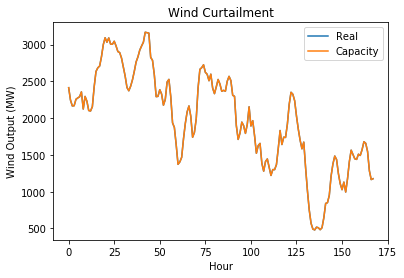

Wind use: 0.9999995638101061


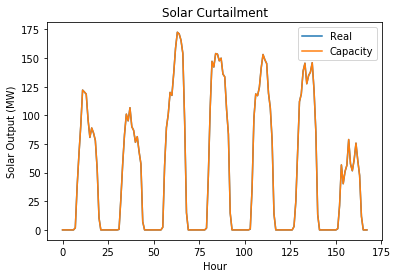

Solar use: 0.9994839577146873
Total cost (real):  104654609.11772227
S:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Battery capacities:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [313]:
(pf_opt, cost, p_opt, theta_opt, 
 lmp_opt, qD_opt, qR_opt, S_opt, Smaxs_opt) = DCOPF(Y, PGl, PGu, PD, thetal, thetau, 
                                                    CQ, CL, PF, slack, gens_to_buses, 
                                                    EFF_IN, EFF_OUT, EFF_STORE, MAX_CHARGE,
                                                    battery_cost, BATTERY_LIFETIME, 10000)
np.set_printoptions(precision=3, suppress=True)
get_wind_curtailment(p_opt, PGu, generators_dict)
get_solar_curtailment(p_opt, PGu, generators_dict)
#print(np.matmul(p_opt**2, CQ.T) + np.matmul(p_opt, CL.T))
#print('OPF:', pf_opt)
#print('Total cost (optimizer):', cost)
print('Total cost (real): ', np.sum(np.matmul(p_opt, gens_to_buses) * lmp_opt))
#print('Generation:', p_opt * SBASE)
#print('Angles:', theta_opt)
#print('LMPs: ', lmp_opt)
#print('qD: ', qD_opt)
#print('qR: ', qR_opt)
print('S: ', S_opt * SBASE)
#print('Angles:', theta_opt)
print('Battery capacities: ', Smaxs_opt*SBASE)
#for gen in generators_dict.keys():
#    print(gen)
#    print(SBASE*PGu[:,generators_dict[gen]['idx']])
#    plt.plot(SBASE*PGu[:,generators_dict[gen]['idx']],label=gen)
#    plt.legend()
#plt.plot(SBASE*np.sum(PGu))

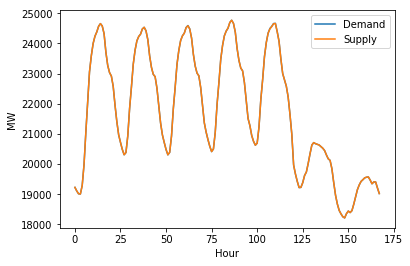

In [314]:
total_demand = np.sum(PD,axis=1)
total_supply = np.sum(p_opt,axis=1)
plt.plot(total_demand*SBASE,label="Demand")
plt.plot(total_supply*SBASE,label="Supply")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()

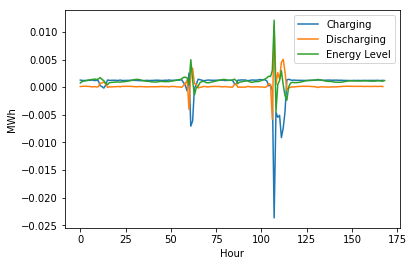

In [315]:
battery_charge = np.sum(qR_opt, axis=1)
battery_discharge = np.sum(qD_opt, axis=1)
battery_level = np.sum(S_opt, axis=1)
plt.plot(battery_charge*SBASE, label="Charging")
plt.plot(battery_discharge*SBASE, label="Discharging")
plt.plot(battery_level*SBASE, label="Energy Level")
plt.xlabel("Hour")
plt.ylabel("MWh")
plt.legend()

In [292]:
print('qD: ', qD_opt * SBASE)
print('qR: ', qR_opt * SBASE)
print('S: ',  S_opt * SBASE)

qD:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0. -0. ... -0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -0. ... -0.  0.  0.]]
qR:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
S:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [122]:
print('Regions: ', regnames)
(pf_opt, cost, p_opt, theta_opt, 
     lmp_opt, qD_opt, qR_opt, S_opt, Smaxs_opt) = DCOPF(Y, PGl, PGu, PD, thetal, thetau, 
                                                        CQ, CL, PF, slack, gens_to_buses, 
                                                        EFF_IN, EFF_OUT, EFF_STORE, MAX_CHARGE,
                                                        5, BATTERY_LIFETIME,10000)
print('Baseline total cost: ', np.sum(np.matmul(p_opt, gens_to_buses) * lmp_opt))

for bcost in range(0, int(360001 * SBASE), int(30000 * SBASE)):
    (pf_opt, cost, p_opt, theta_opt, 
     lmp_opt, qD_opt, qR_opt, S_opt, Smaxs_opt) = DCOPF(Y, PGl, PGu, PD, thetal, thetau, 
                                                        CQ, CL, PF, slack, gens_to_buses, 
                                                        EFF_IN, EFF_OUT, EFF_STORE, MAX_CHARGE,
                                                        bcost, BATTERY_LIFETIME, 10000)
    print('Total cost (real): ', np.sum(np.matmul(p_opt, gens_to_buses) * lmp_opt) +
                                    np.sum(NUM_HOURS*Smaxs_opt*SBASE*bcost/BATTERY_LIFETIME))
    np.set_printoptions(precision=2, suppress=True)
    print('Cost: ', bcost/(1000*SBASE), '$/kWh\tCapacities: ', Smaxs_opt*SBASE+.001)

Regions:  ['North', 'West', 'FarWest', 'NorthCentral', 'East', 'SouthCentral', 'South', 'Coast', 'Northwest']
Baseline total cost:  8953444.882987108
Total cost (real):  8975768.759124475
Cost:  0.0 $/kWh	Capacities:  [8450495.93 8450983.95 8449945.03 8447902.86 8451176.96 8451119.75
 8443148.54 8451152.48 8447645.66]
Total cost (real):  92602170.88155898
Cost:  30.0 $/kWh	Capacities:  [   0.      0.   1289.01 1811.38    0.      0.   6201.48    0.    933.08]
Total cost (real):  105317431.15568228
Cost:  60.0 $/kWh	Capacities:  [   0.      0.    775.91  159.2     0.      0.   4974.1     0.      0.  ]
Total cost (real):  8994522.987215362
Cost:  90.0 $/kWh	Capacities:  [ 0.    0.   36.33  0.    0.    0.    0.    0.    0.  ]
Total cost (real):  8089662.0240907185
Cost:  120.0 $/kWh	Capacities:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total cost (real):  8089637.297725362
Cost:  150.0 $/kWh	Capacities:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total cost (real):  8088892.166957429
Cost:  180.0 $/kWh	Capacities: 